In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn

with open(r"arguments.txt") as f:
    args = f.read().splitlines()

image_name = args[0]
prompts = [i.strip() for i in args[1].split(".")]
threshold = float(args[2])

IMAGE_PATH = image_name + ".png"
image = Image.open(IMAGE_PATH)

In [6]:
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)

# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

In [13]:
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_threshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_threshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_threshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

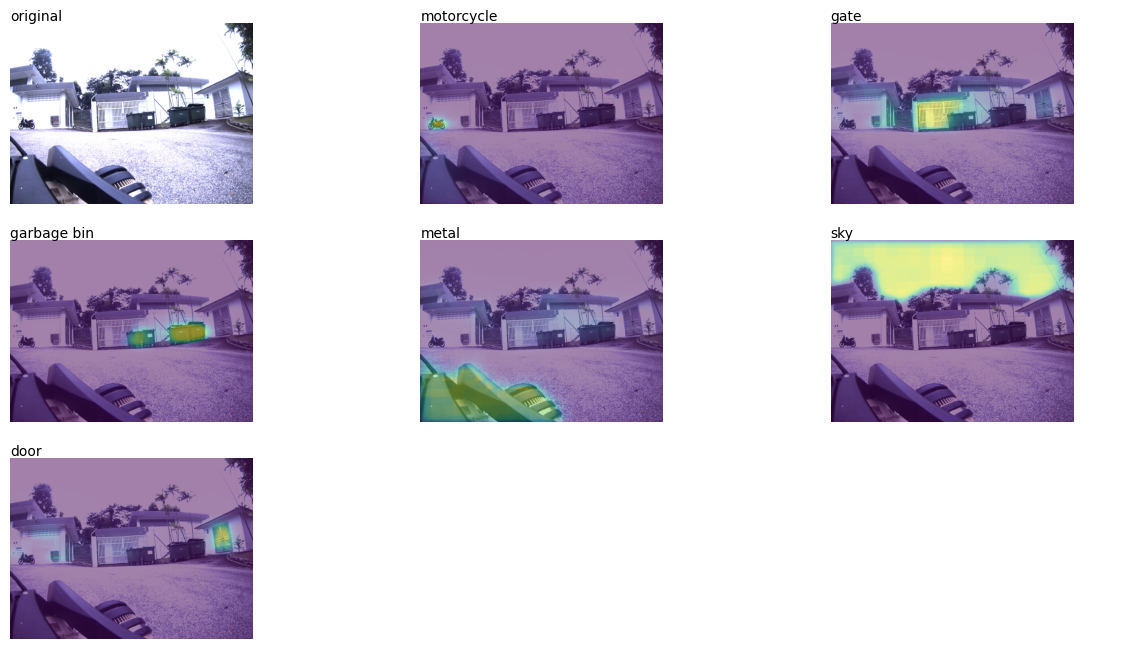

In [14]:
# show masks by prompt
n_prompts = len(prompts) + 1

nrows = (n_prompts // 3 + 1) if (n_prompts % 3) else (n_prompts // 3)
masks, ax = plt.subplots(nrows, 3, figsize=(15, 8))
[a.axis('off') for a in ax.flatten()]
ax = ax.flatten()

# original
ax[0].imshow(image)
ax[0].text(0, -15, "original")

# masks
[ax[i+1].imshow(image) for i in range(n_prompts-1)]
[ax[i+1].imshow(torch.sigmoid(preds[i][0]), alpha=0.5) for i in range(n_prompts-1)]
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)]

masks.savefig(image_name + "-indiv-masks.png", bbox_inches="tight")

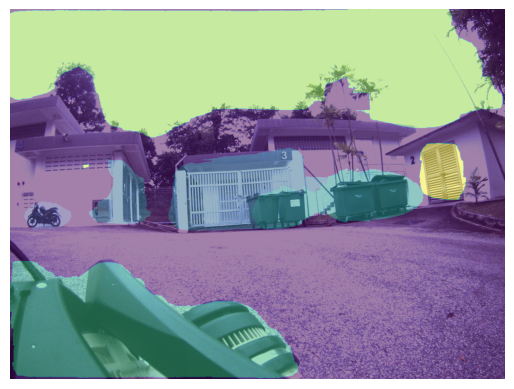

In [15]:
fig = plt.axis('off')
fig = plt.imshow(image)
fig = plt.imshow(inds, alpha=0.5)

plt.savefig(image_name + "-top-masks.png", bbox_inches="tight")